## ***AI-Powered Sales Forecasting Dashboard using Prophet & Power BI***

In [2]:
!pip install pandas matplotlib seaborn plotly prophet openpyxl

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")


## ***Here we install all the required libraries.***


pandas for data handling

matplotlib and seaborn for visualization

prophet for forecasting

openpyxl for Excel output
We also suppress warnings for a cleaner output.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving holidays_events.csv to holidays_events.csv
Saving oil.csv to oil.csv
Saving sample_submission.csv to sample_submission.csv
Saving stores.csv to stores.csv
Saving test.csv to test.csv
Saving train.csv to train.csv
Saving transactions.csv to transactions.csv


In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
transactions = pd.read_csv('transactions.csv')
stores = pd.read_csv('stores.csv')
holidays = pd.read_csv('holidays_events.csv')
oil = pd.read_csv('oil.csv')

# Convert date columns
train['date'] = pd.to_datetime(train['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

train = train.sort_values('date')


All datasets are loaded using pd.read_csv().
Date columns are converted to datetime format for easier manipulation later.
The main dataset train is sorted by date.

In [7]:
# Merge stores
train = pd.merge(train, stores, on='store_nbr', how='left')

# Merge transactions
train = pd.merge(train, transactions, on=['date', 'store_nbr'], how='left')

# Merge oil prices (economic indicator)
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='ffill')
train = pd.merge(train, oil, on='date', how='left')

# Merge holidays
holidays_filtered = holidays[(holidays['locale'] == 'National') & (holidays['transferred'] == False)]
holidays_filtered['is_holiday'] = 1
train = pd.merge(train, holidays_filtered[['date', 'is_holiday']], on='date', how='left')
train['is_holiday'] = train['is_holiday'].fillna(0)


Here, we enrich the training data using:

stores.csv to get store type and cluster

transactions.csv for customer activity

oil.csv for economic conditions

holidays.csv to add holiday flags

In [11]:
# Extract date-related features
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek
train['week'] = train['date'].dt.isocalendar().week

# Sort by store and date for rolling average
train = train.sort_values(['store_nbr', 'date'])

# 7-day rolling average of sales per store
train['rolling_sales_7'] = train.groupby('store_nbr')['sales'].transform(lambda x: x.rolling(7).mean())


In this step, we do feature engineering — converting the date column into useful features such as:

year, month, day: for time-based analysis

dayofweek: to capture weekday/weekend patterns

week: ISO calendar week number

We also calculate a 7-day rolling average of sales for each store, which helps smooth out short-term fluctuations and shows recent trends more clearly.

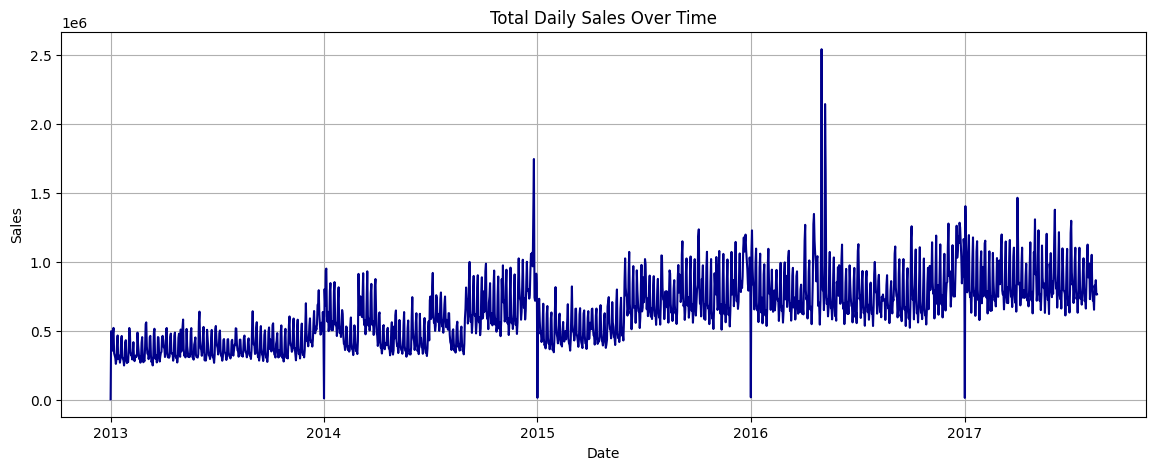

In [12]:
daily_sales = train.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(14, 5))
sns.lineplot(data=daily_sales, x='date', y='sales', color='darkblue')
plt.title("Total Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


We plot the total daily sales trend using seaborn to understand the seasonality and identify patterns in sales volume.

In [13]:
# Rename for Prophet
df_prophet = daily_sales.rename(columns={'date': 'ds', 'sales': 'y'})


Prophet requires columns named ds (date) and y (value).
We rename accordingly.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpay63buqn/asmjscvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpay63buqn/lh9j_am5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69273', 'data', 'file=/tmp/tmpay63buqn/asmjscvc.json', 'init=/tmp/tmpay63buqn/lh9j_am5.json', 'output', 'file=/tmp/tmpay63buqn/prophet_modelnnoou2cn/prophet_model-20250716050835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:08:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:08:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


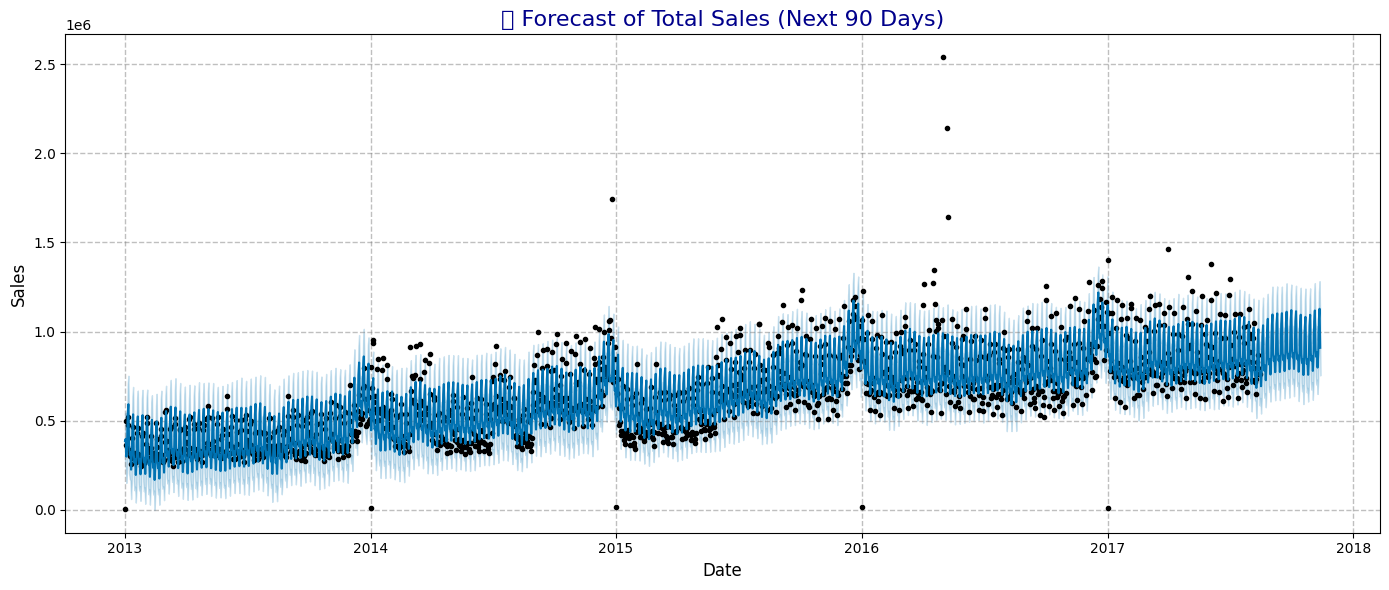

In [15]:
# Train Prophet model (same as before)
model = Prophet()
model.fit(df_prophet)

# Forecast for next 90 days
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Plot forecast with custom style
fig = plt.figure(figsize=(14, 6))  # Wider figure
ax = fig.add_subplot()

# Plot actual + forecasted data
model.plot(forecast, ax=ax)

# Customize plot
ax.set_title("📈 Forecast of Total Sales (Next 90 Days)", fontsize=16, color='darkblue')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Sales", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


We initialize and train the Prophet model.
The model then forecasts sales for the next 90 days.
The plot shows actual sales and predicted values with confidence intervals.

In [16]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_excel("sales_forecast.xlsx", index=False)

# Download file
from google.colab import files
files.download("sales_forecast.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The forecasted results are saved to an Excel file, which can be used in Power BI to build a dashboard.

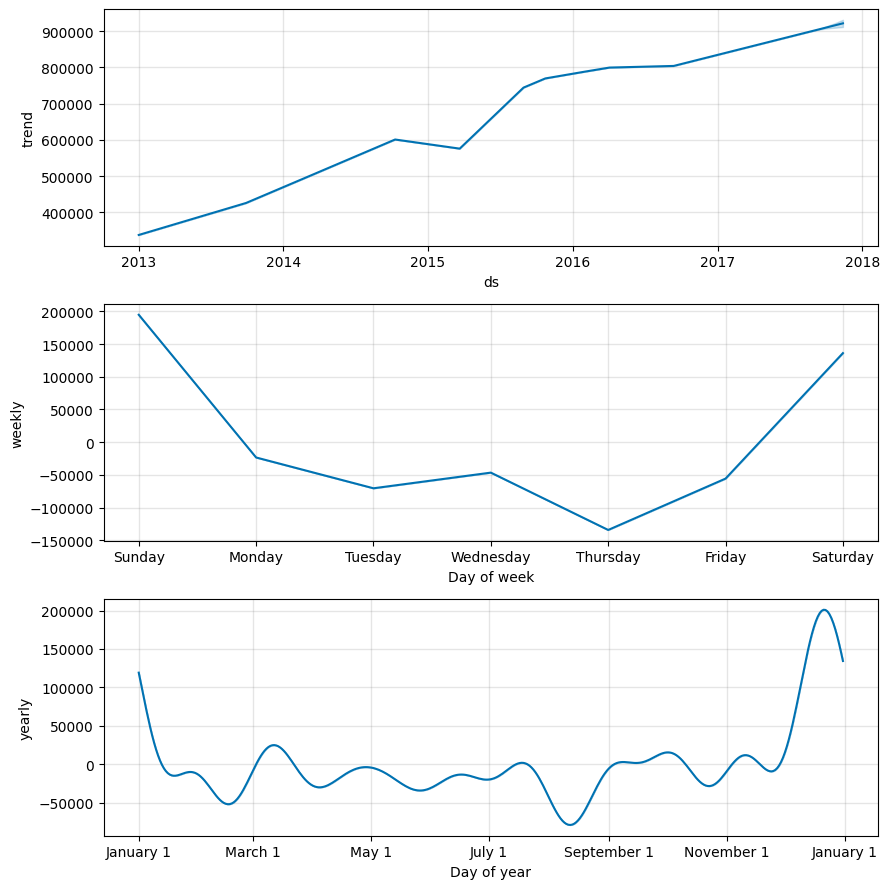

In [17]:
model.plot_components(forecast)
plt.tight_layout()
plt.show()


This shows the seasonality components like weekly pattern, yearly trends, and holidays impact.